In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Input
from tensorflow.keras.utils import to_categorical
import tensorflow as tf


In [8]:
def load_processed_data(dataset):
    df = pd.read_csv(f"../data/processed/train_{dataset}.csv")
    df["label"] = (df["RUL"] <= 30).astype(int)  # 1 = near-failure
    return df

In [9]:
def make_sequences(data, feature_cols, label_col="label", seq_len=30):
    sequences, labels = [], []
    units = data["unit_number"].unique()
    for unit in units:
        unit_data = data[data.unit_number == unit]
        X = unit_data[feature_cols].values
        y = unit_data[label_col].values
        for i in range(len(X) - seq_len):
            sequences.append(X[i:i+seq_len])
            labels.append(y[i+seq_len])
    return np.array(sequences), np.array(labels)

In [10]:
#Build models
def build_lstm(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_tcn(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation="relu", input_shape=input_shape),
        Conv1D(64, kernel_size=3, activation="relu"),
        Flatten(),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [11]:
def evaluate_model(model, X_val, y_val, name):
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1": f1_score(y_val, y_pred)
    }

In [12]:
datasets = ["FD001", "FD002", "FD003", "FD004"]
feature_cols = [c for c in pd.read_csv("../data/processed/train_FD001.csv").columns 
                if c not in ["unit_number", "time_in_cycles", "RUL", "label"]]

all_results = {}

for ds in datasets:
    print(f"\n🔹 Running {ds} ...")
    df = load_processed_data(ds)
    X, y = make_sequences(df, feature_cols, seq_len=30)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train LSTM
    lstm = build_lstm((X_train.shape[1], X_train.shape[2]))
    lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64, verbose=0)
    
    # Train TCN
    tcn = build_tcn((X_train.shape[1], X_train.shape[2]))
    tcn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64, verbose=0)

    results = []
    results.append(evaluate_model(lstm, X_val, y_val, "LSTM"))
    results.append(evaluate_model(tcn, X_val, y_val, "TCN"))
    
    dl_results = pd.DataFrame(results)
    best_dl = dl_results.sort_values("F1", ascending=False).iloc[0]

    rf_baseline = {
        "FD001": {"Accuracy":0.9646,"Precision":0.9047,"Recall":0.8580,"F1":0.8807},
        "FD002": {"Accuracy":0.9559,"Precision":0.9055,"Recall":0.8021,"F1":0.8507},
        "FD003": {"Accuracy":0.9686,"Precision":0.9126,"Recall":0.8419,"F1":0.8758},
        "FD004": {"Accuracy":0.9543,"Precision":0.8206,"Recall":0.8290,"F1":0.8248},
    }
    rf_result = {"Model": "Random Forest", **rf_baseline[ds]}
    
    comparison_df = pd.concat([dl_results, pd.DataFrame([rf_result])], ignore_index=True)

    all_results[ds] = {"dl_results": dl_results, "comparison": comparison_df, "best_final": comparison_df.sort_values("F1", ascending=False).iloc[0]}



🔹 Running FD001 ...


d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
 19/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

🔹 Running FD002 ...


d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 26/288 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

🔹 Running FD003 ...


d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
  1/136 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step

d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

🔹 Running FD004 ...


d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\ai_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
 36/337 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

d:\ai_predictive_maintenance\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step



📊 FD001 Comparison


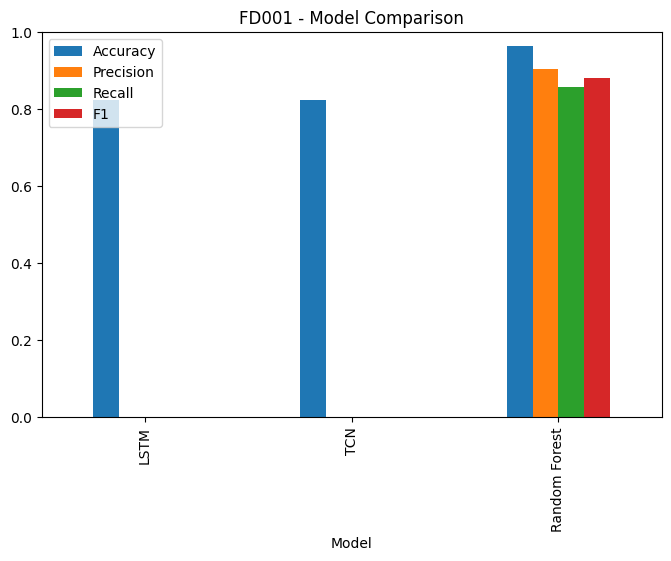

✅ Final Selected Model: Random Forest

📊 FD002 Comparison


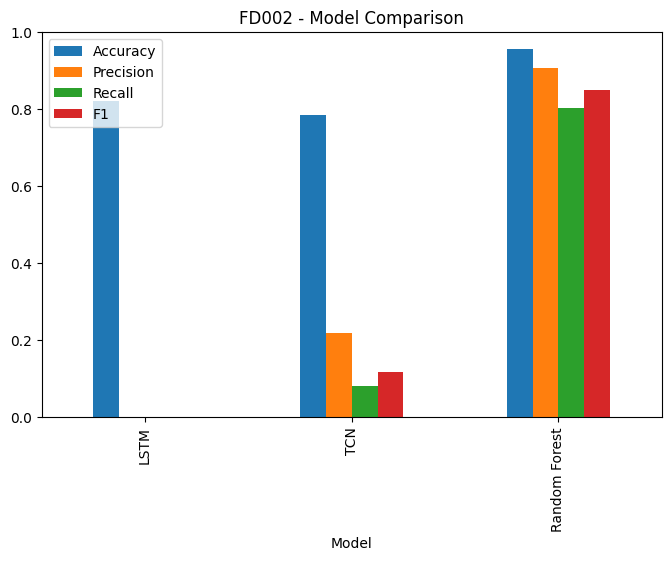

✅ Final Selected Model: Random Forest

📊 FD003 Comparison


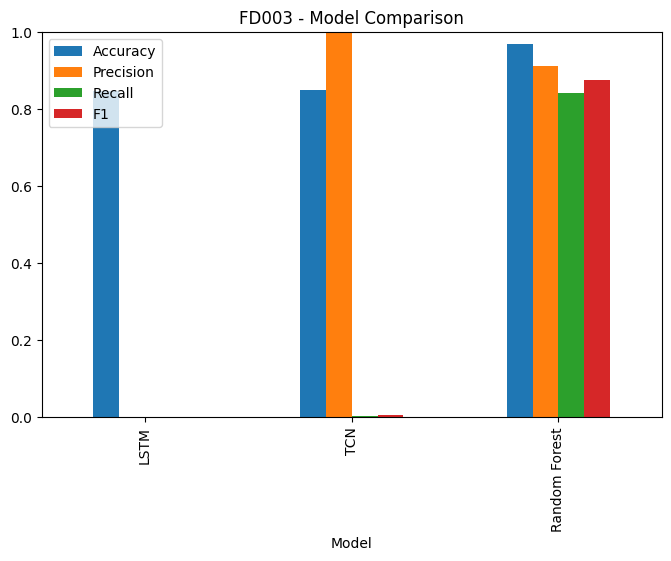

✅ Final Selected Model: Random Forest

📊 FD004 Comparison


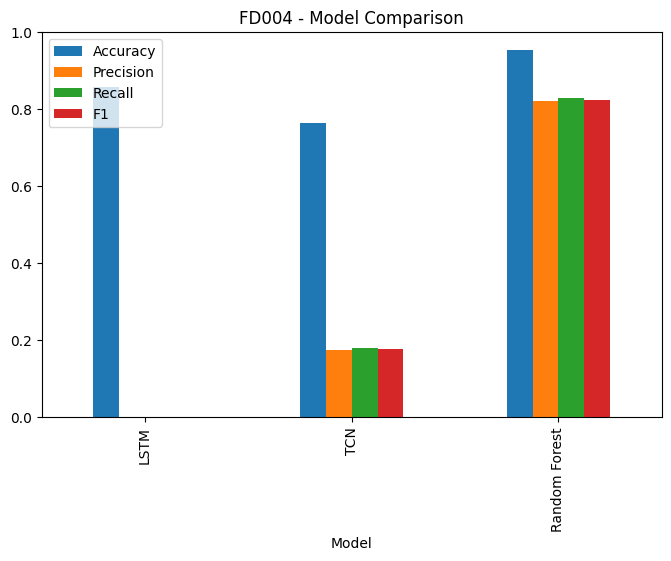

✅ Final Selected Model: Random Forest


In [13]:
for ds in datasets:
    print(f"\n📊 {ds} Comparison")
    comp = all_results[ds]["comparison"]
    comp.plot(x="Model", y=["Accuracy","Precision","Recall","F1"], kind="bar", figsize=(8,5))
    plt.title(f"{ds} - Model Comparison")
    plt.ylim(0,1)
    plt.show()
    print("✅ Final Selected Model:", all_results[ds]["best_final"]["Model"])